In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

In [2]:
bbox = np.load('../omni.replicator_out/left_arm_output/bounding_box_2d_tight_0000.npy')
img = Image.open('../omni.replicator_out/left_arm_output/rgb_0000.png')

In [3]:
def draw_boxes_on_img(img, bboxes):
    

    fig, ax = plt.subplots()

    ax.imshow(img)

    for box in bboxes:
        _, x1, y1, x2, y2, _ = box

        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='g', facecolor='none')

        ax.add_patch(rect)

    plt.show()

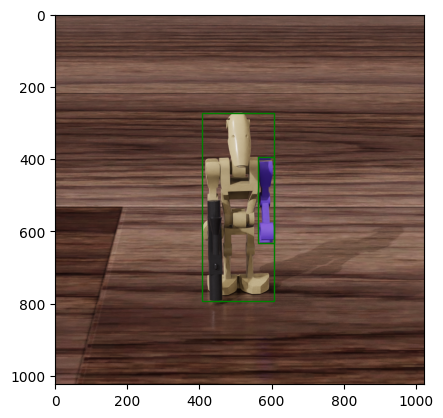

In [4]:
draw_boxes_on_img(img, bbox)

In [6]:
# First, take real photos and label them using label-studio

# in the future, make omniverse 1280x720 or 640x640
label_map = {
    'droid': 0,
    'head_defect': 1,
    'left_arm_defect': 2, 
    'right_arm_defect': 3,
    'torso_defect': 4, 
    'legs_defect': 5
}

In [6]:
import uuid
import os
from glob import glob
# iterate through all images and labels from label_studio labels
# move rename the files and move to new data directory

# create images and labels subfolders if they don't exist yet

if not os.path.exists('data/images'):
    os.mkdir('data/images')
if not os.path.exists('data/labels'):
    os.mkdir('data/labels')


label_studio_path = 'label-studio_labels'
label_studio_img_suffix = '.jpg'

for imgfile in glob(os.path.join(label_studio_path, 'images', '*.jpg')):
    # create uuid to name the new files
    name = uuid.uuid4().__str__()

    # move(rename) image file to data directory
    labelfile = imgfile.replace('images', 'labels').replace(label_studio_img_suffix, '.txt')

    os.rename(
        imgfile,
        os.path.join('data', 'images', name + label_studio_img_suffix)
    )

    os.rename(
        labelfile,
        os.path.join('data', 'labels', name + '.txt')
    )
    


In [7]:
import re

omni_output_dir = '../omni.replicator_out/'

bbox_pattern = 'bounding_box_2d_tight_{}.npy'

omni_dims = (1024, 1024)

In [8]:
def create_ultralytics_label(
        bboxes: np.ndarray,
        dims: tuple,
        filepath: str,
        defect_class: int
): 
    """
    Function that writes an ultralytics .txt label from a given set of bboxes and labels

    Args:
        bbox: An array of bboxes in omniverse output format
        dims: Dimensions of the image
        id: string to name the .txt file and image
    """
    # target file path for the label's .txt file

    img_width, img_height = dims

    with open(filepath, 'w') as f:

        for bbox in bboxes:
            # unpack values from each bbox
            cls, x1, y1, x2, y2, _ = bbox

            if cls != 0:
                label = defect_class
            else:
                label = 0
                

            x_center = (x1 + (x2 - x1) / 2) / img_width
            y_center = (y1 + (y2 - y1) / 2) / img_height

            box_width = (x2 - x1) / img_width
            box_height = (y2 - y1) / img_height

        
            f.write(f'{label}\t{x_center}\t{y_center}\t{box_width}\t{box_height}\n')      



In [9]:
# iterate through each output folder and rename/move all images and labels

# outer loop over folders
for foldername in glob(omni_output_dir + '*'):
    # get defect index from label map and folder name
    defect_idx = label_map[foldername.split('\\')[-1].replace('_output', '_defect')]
    
    # iterate over images in the folder
    for imgfile in glob(foldername + '/*.png'):
        name = uuid.uuid4().__str__()

        assert re.search(r'\d+', imgfile), 'image id not found'
        img_id = re.findall(r'\d+', imgfile)[0]

        # rename imgfile to data directory
        os.rename(
            imgfile,
            os.path.join('data', 'images', name + '.png')
        )

        # create ultralytics label file from bboxes

        # load bboxes
        bbox_path = os.path.join(foldername, bbox_pattern.format(img_id))
        bboxes = np.load(bbox_path)

        labelpath = os.path.join('data', 'labels', name + '.txt')

        create_ultralytics_label(bboxes, omni_dims, labelpath, defect_idx)

        

In [10]:
import random
# split images into train and test folders
if not os.path.exists('data/images/val'):
    os.mkdir('data/images/val')

if not os.path.exists('data/images/train'):
    os.mkdir('data/images/train')

if not os.path.exists('data/labels/val'):
    os.mkdir('data/labels/val')

if not os.path.exists('data/labels/train'):
    os.mkdir('data/labels/train')

val_prop = .2

for imgfile in os.listdir(os.path.join('data', 'images')):
    if not imgfile.endswith('.png') and not imgfile.endswith('.jpg'): # ignore train and val folders
        continue

    r = random.random()
    labelfile = imgfile.replace('.png', '.txt').replace('.jpg', '.txt')
    if r < val_prop:
        # move image and label into val subfolder
        os.rename(os.path.join('data', 'images', imgfile), os.path.join('data', 'images', 'val', imgfile))
        os.rename(os.path.join('data', 'labels', labelfile), os.path.join('data', 'labels', 'val', labelfile))
    else:
        # move image and label into train subfolder
        os.rename(os.path.join('data', 'images', imgfile), os.path.join('data', 'images', 'train', imgfile))
        os.rename(os.path.join('data', 'labels', labelfile), os.path.join('data', 'labels', 'train', labelfile))



In [7]:
# create data.yaml

filename = 'data/data.yaml'

with open(filename, 'w') as f:
    f.write('path: ../data\n')
    f.write('train: images/train\n')
    f.write('val: images/val\n')
    f.write('\nnames:\n')
    for key, val in label_map.items():
        f.write(f'  {val}: {key}\n')

In [9]:
from ultralytics import YOLO

# load pretrained model
model = YOLO('yolo11m.pt')

# model training
results = model.train(data='data/data.yaml', epochs=15, val=True, device=0)

New https://pypi.org/project/ultralytics/8.3.55 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.40  Python-3.8.20 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolo11m.pt, data=data/data.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

train: Scanning C:\Users\Hckra\quality\data\labels\train.cache... 402 images, 0 backgrounds, 0 corrupt: 100%|██████████| 402/402 [00:00<?, ?it/s]
val: Scanning C:\Users\Hckra\quality\data\labels\val.cache... 130 images, 0 backgrounds, 0 corrupt: 100%|██████████| 130/130 [00:00<?, ?it/s]


Plotting labels to runs\detect\train6\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train6
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      8.87G     0.8714      2.691       1.16          4        640: 100%|██████████| 26/26 [00:56<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:59<00:00, 11.85s/it]

                   all        130        257      0.668      0.724      0.862      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      8.64G     0.6427      1.036     0.9901          9        640: 100%|██████████| 26/26 [00:51<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]

                   all        130        257      0.594      0.863      0.747      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      8.66G     0.6519     0.8007      0.983          6        640: 100%|██████████| 26/26 [01:14<00:00,  2.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.97s/it]

                   all        130        257      0.785      0.795      0.879      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      8.62G     0.6297     0.7307     0.9653          9        640: 100%|██████████| 26/26 [01:06<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

                   all        130        257      0.663      0.857      0.927      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      8.61G     0.5968     0.6313     0.9744         11        640: 100%|██████████| 26/26 [00:36<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]

                   all        130        257      0.961      0.919      0.975      0.829


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      8.63G     0.4628     0.4681     0.8694          4        640: 100%|██████████| 26/26 [00:29<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]

                   all        130        257      0.869      0.941      0.977      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15       8.6G     0.4558     0.4309     0.8713          4        640: 100%|██████████| 26/26 [00:31<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]

                   all        130        257      0.835      0.845      0.953      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      8.64G     0.4201        0.4     0.8499          4        640: 100%|██████████| 26/26 [00:28<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]

                   all        130        257      0.969      0.797      0.977      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      8.59G     0.3781     0.3499     0.8356          4        640: 100%|██████████| 26/26 [00:31<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]

                   all        130        257      0.923      0.918      0.984      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      8.65G     0.3688     0.3336     0.8308          4        640: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]

                   all        130        257       0.98      0.982      0.979      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      8.61G     0.3424     0.3156     0.8202          4        640: 100%|██████████| 26/26 [00:58<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.92s/it]

                   all        130        257      0.986      0.981      0.986      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      8.63G     0.3136     0.2921     0.8143          4        640: 100%|██████████| 26/26 [00:45<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:12<00:00,  2.44s/it]

                   all        130        257      0.995      0.978      0.985      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      8.67G     0.2806     0.2672     0.7994          4        640: 100%|██████████| 26/26 [00:55<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

                   all        130        257      0.991      0.986       0.99       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      8.64G     0.2585     0.2443     0.7854          4        640: 100%|██████████| 26/26 [00:30<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]

                   all        130        257      0.994      0.983       0.99       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      8.59G     0.2364     0.2329     0.7904          4        640: 100%|██████████| 26/26 [00:41<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]

                   all        130        257      0.995      0.985       0.99      0.946



15 epochs completed in 0.268 hours.
Optimizer stripped from runs\detect\train6\weights\last.pt, 40.5MB
Optimizer stripped from runs\detect\train6\weights\best.pt, 40.5MB

Validating runs\detect\train6\weights\best.pt...
Ultralytics 8.3.40  Python-3.8.20 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8192MiB)
YOLO11m summary (fused): 303 layers, 20,034,658 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


                   all        130        257      0.995      0.985       0.99      0.946
                 droid        130        130      0.999          1      0.995      0.991
           head_defect         15         15       0.99          1      0.995      0.945
       left_arm_defect         31         31      0.997      0.968      0.969      0.896
      right_arm_defect         30         30      0.995          1      0.995      0.898
          torso_defect         27         27       0.99      0.963      0.994      0.974
           legs_defect         24         24          1      0.977      0.995      0.973
Speed: 0.5ms preprocess, 19.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train6
